In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd
import os
import pandas as pd
import json
from itertools import compress
import math

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows

def intersection(lst1, lst2): 
    tup1 = map(tuple, lst1) 
    tup2 = map(tuple, lst2)  
    return list(map(list, set(tup1).intersection(tup2))) 

def reject_outliers(data, m=2):
    # create index of data
    index = list(data.index)
    # check where to remove outliers with 2 sigma distance
    outlier_bool = abs(data - np.mean(data)) < m * np.std(data)
    
    # apply to index and data and return
    return data[outlier_bool], list(compress(index, outlier_bool))


In [2]:
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

In [3]:
print(REFERENCE_DATA_ALL_EVENTS_FAILED["Westbrueck"][0].columns)

Index(['CarPosition.x', 'CarPosition.y', 'CarPosition.z', 'CarRotation.x',
       'CarRotation.y', 'CarRotation.z'],
      dtype='object')


# Load data

In [4]:

eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]


measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,True)


MeasurementData: Found files for participant 0d0d7bd79b1a48d4ad5e757cdbfc15c9.
Input data files: ['./data/Input/0d0d7bd79b1a48d4ad5e757cdbfc15c9_Input_TrainingScene.txt', './data/Input/0d0d7bd79b1a48d4ad5e757cdbfc15c9_Input_Westbrueck.txt', './data/Input/0d0d7bd79b1a48d4ad5e757cdbfc15c9_Input_CountryRoad.txt', './data/Input/0d0d7bd79b1a48d4ad5e757cdbfc15c9_Input_Autobahn.txt', './data/Input/0d0d7bd79b1a48d4ad5e757cdbfc15c9_Input_MountainRoad.txt']
Eyetracking data files: ['./data/EyeTracking/0d0d7bd79b1a48d4ad5e757cdbfc15c9_EyeTracking_Westbrueck.txt', './data/EyeTracking/0d0d7bd79b1a48d4ad5e757cdbfc15c9_EyeTracking_Autobahn.txt', './data/EyeTracking/0d0d7bd79b1a48d4ad5e757cdbfc15c9_EyeTracking_MountainRoad.txt', './data/EyeTracking/0d0d7bd79b1a48d4ad5e757cdbfc15c9_EyeTracking_TrainingScene.txt', './data/EyeTracking/0d0d7bd79b1a48d4ad5e757cdbfc15c9_EyeTracking_CountryRoad.txt']
Calibration data files: ['./data/ParticipantCalibrationData/0d0d7bd79b1a48d4ad5e757cdbfc15c9_ParticipantCalib

In [5]:
#print(participant1.get_event_info())
#participant1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))

measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
ParticipantData: Applying reference data to back of Coun

In [6]:
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))


# Filter data

In [7]:
# Wanted filtering, very much data
'''
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
res = measurement1.truncate_data(filtered_data,200)
print(np.shape(res))
# save_to_disk(res,"./truncated_data.pickle")
'''


# some test filtering
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn","MountainRoad"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = True, after_event_type_only=[True,False], exclude_segments=[], exclude_areas = [], exclude_participants=[])

#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])




#print(filtered_data)
print(filtered_data['0d0d7bd79b1a48d4ad5e757cdbfc15c9']["Westbrueck"][0].columns)



ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.
Index(['HmdPosition.x', 'HmdPosition.y', 'H

In [8]:
# Average data over multiple sessions per segment
average = measurement1.average_data(filtered_data)

# combine ALL data into one dataframe 
#combined = measurement1.combine_data(filtered_data)


## Spectral density

In [9]:
# Extract data of one participant, of one area, of one segment 
print("Available participants: " + str(measurement1.get_participant_list()))
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 get_first_segment=False, after_event_type_only=[True,False], \
                 exclude_areas=[], exclude_segments=[], \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment = one_participant_single_segment['0bc17d704fec4a9eb892d905fc2e5da9']["Westbrueck"][1]

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = True, after_event_type_only=[True,False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants["Westbrueck"][1]


Available participants: ['0d0d7bd79b1a48d4ad5e757cdbfc15c9', '0bc17d704fec4a9eb892d905fc2e5da9']
ParticipantData: Filtering data with manual settings.
ParticipantData: Filtering data with manual settings.
ParticipantData: Filtering data with manual settings.


/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [10]:
one_participant_single_segment

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z,resampled_timestamp,is_interpolated
0,0.250366,1.034218,-0.322266,-358.406220,-238.675575,-0.417390,0.265152,1.036537,-0.292114,-358.419574,-238.954663,-0.455890,3.53,False
1,0.297546,1.032471,-0.302368,-358.424856,-239.026360,-0.390096,0.313370,1.034637,-0.275513,-358.438295,-239.307459,-0.428331,3.54,False
2,0.296974,1.032562,-0.305298,-358.430495,-239.381532,-180.359210,0.312607,1.034660,-0.277344,-358.444108,-239.662608,-180.397379,3.55,True
3,0.296402,1.032654,-0.308228,-358.436133,-239.736704,-360.328325,0.311844,1.034683,-0.279175,-358.449921,-240.017758,-360.366427,3.56,False
4,0.295753,1.032654,-0.313354,-358.436254,-240.464647,-360.275014,0.313454,1.034454,-0.291138,-358.445637,-240.743147,-360.323883,3.57,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0.251198,1.042816,-0.401978,-357.351543,-261.067640,-358.146998,0.271111,1.044968,-0.371948,-357.333992,-261.276258,-358.435330,24.79,False
2127,0.254776,1.042587,-0.400513,-357.332032,-260.685175,-358.174329,0.274292,1.044609,-0.375488,-357.313596,-260.899536,-358.461889,24.80,True
2128,0.317627,1.038681,-0.381226,-357.286886,-259.930794,-358.221633,0.336746,1.040573,-0.361206,-357.267565,-260.150895,-358.508422,24.81,False
2129,0.264313,1.041924,-0.396118,-357.286281,-259.930512,-358.227559,0.282814,1.043701,-0.382446,-357.266170,-260.149722,-358.511654,24.82,True


In [11]:
def anglebetween(v1, v2):
    v1Norm = v1/np.linalg.norm(v1)
    v2Norm = v2/np.linalg.norm(v2)
    Dot = np.dot(v1Norm, v2Norm)
    angle = math.degrees(np.arccos(Dot))
    
    return angle

In [29]:
# TODO: fix this 
######## 
names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]
idx = 0
########

v1_list = one_participant_single_segment[['EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z']]
#v1_list = v1_list[:len(v1_list)]
v1_list = v1_list.reset_index(drop=True)
v2_list =  one_participant_single_segment[['NoseVector.x', 'NoseVector.y', 'NoseVector.z']]#.shift()
#v2_list = v2_list[1:]
v2_list = v2_list.reset_index(drop=True)

#### TODO: fix this 
#### names_x & idx 
x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180 
x_out, index = reject_outliers(x)
    
    

angles_EyeDir = []

for idx in range(len(v1_list)-1):
    
    v1 = []
    v1.append(v1_list.loc[idx, 'EyeDirWorldCombined.x'])
    v1.append(v1_list.loc[idx, 'EyeDirWorldCombined.y'])
    v1.append(v1_list.loc[idx, 'EyeDirWorldCombined.z'])
    
    #v1 = np.array(v1)
    
    v2 = []
    v2.append(v2_list.loc[idx, 'NoseVector.x'])
    v2.append(v2_list.loc[idx, 'NoseVector.y'])
    v2.append(v2_list.loc[idx, 'NoseVector.z'])
    
    #v2 = np.array(v2)
    
    angles_EyeDir.append(anglebetween(v1, v2))



(array([1.159e+03, 1.170e+03, 3.100e+01, 3.300e+01, 3.900e+01, 1.100e+01,
        3.000e+00, 1.000e+00, 0.000e+00, 3.600e+01]),
 array([0.00027404, 0.01904946, 0.03782488, 0.05660029, 0.07537571,
        0.09415113, 0.11292655, 0.13170196, 0.15047738, 0.1692528 ,
        0.18802821]),
 <BarContainer object of 10 artists>)

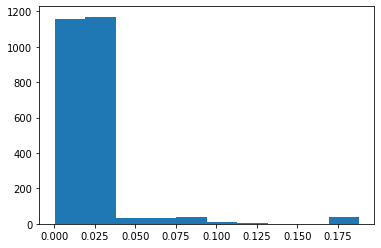

In [157]:
plt.hist(angles_EyeDir)

In [141]:
v1 = np.array([1, 0, 0])
v2 = np.array([0, 0, 1])

v1Norm = v1/np.linalg.norm(v1)
v2Norm = v2/np.linalg.norm(v2)
Dot = np.dot(v1Norm, v2Norm)
angle = np.arccos(Dot)
    
print(str(v1Norm), str(v2Norm), str(Dot), str(math.degrees(angle)))

[1. 0. 0.] [0. 0. 1.] 0.0 90.0


# Raw Participant Data - Nose Vector and Eye Dir Vector

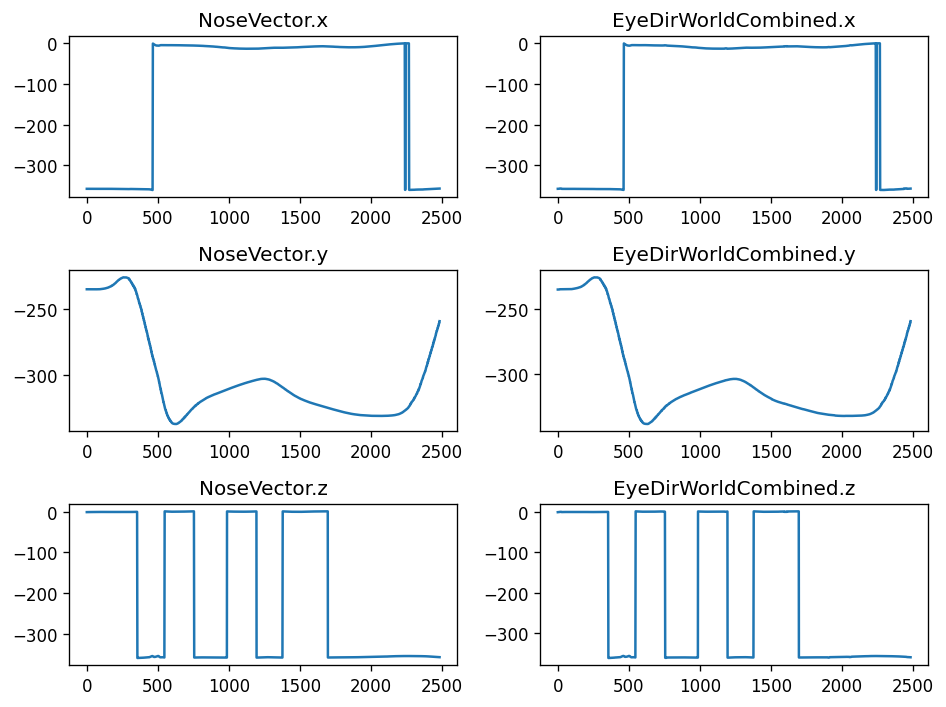

In [153]:
# testing to remove outliers from the angles of nose and eye direction
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)


for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    
    row.plot(x)
    row.set_title(names_x[idx])

    
fig.tight_layout()
plt.show()

# Power Spectral Density on raw data

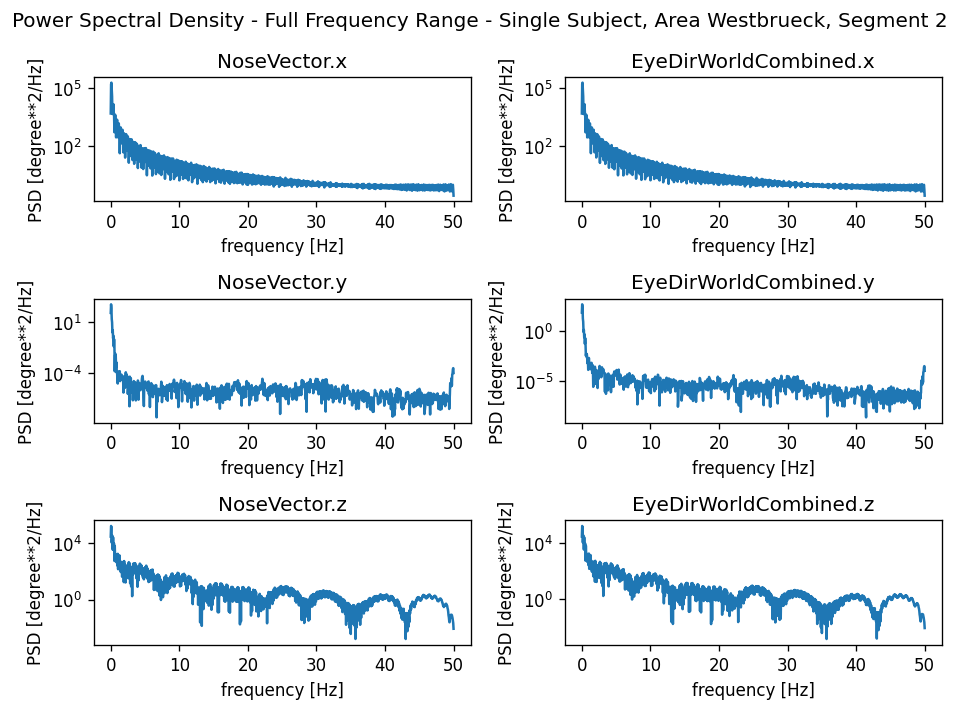

In [16]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 100])
    #row.set_xlim([0, 2])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

In [37]:
one_participant_single_segment[names_x[idx]][510:520]

510     -0.459329
511     -0.443275
512   -120.352703
513   -240.249767
514   -360.149136
515   -360.150607
516   -360.034345
517   -359.918084
518   -359.813577
519   -359.709070
Name: EyeDirWorldCombined.z, dtype: float64

# Rearranging the angles from [0, 360] to [-180, 180]

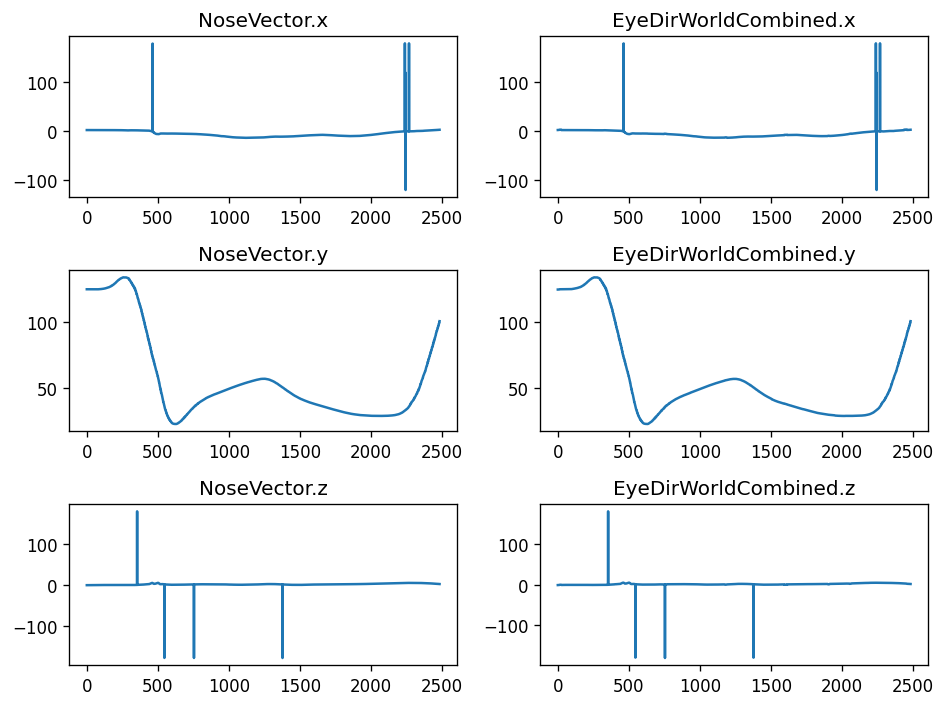

In [154]:
# testing to remove outliers from the angles of nose and eye direction
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
    
    row.plot(x)
    row.set_title(names_x[idx])

    
fig.tight_layout()
plt.show()

# Removing outliers (2 sigma)

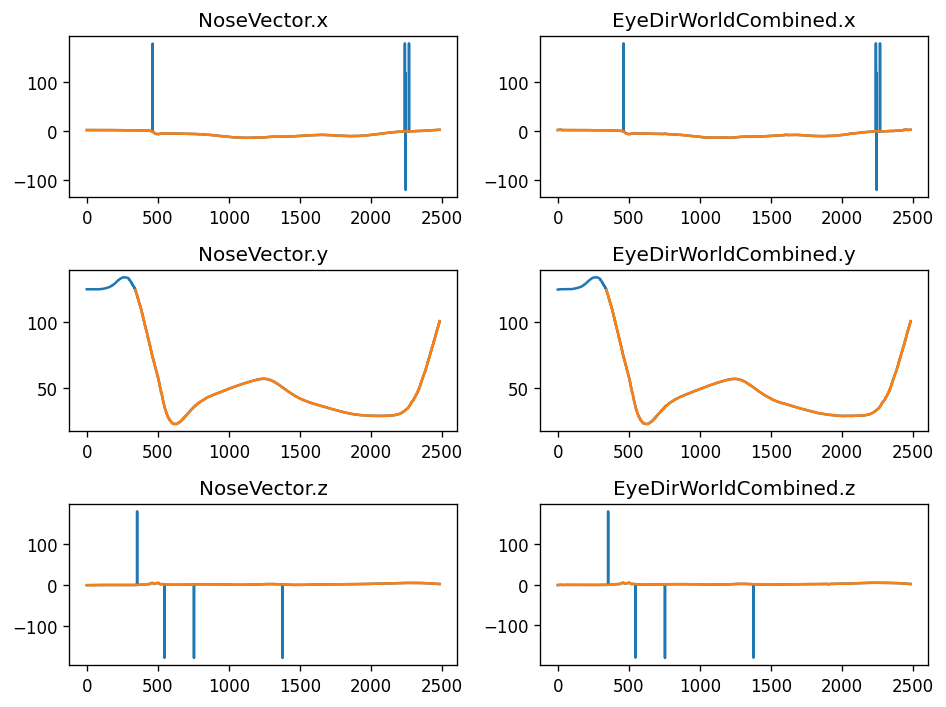

In [155]:
# testing to remove outliers from the angles of nose and eye direction
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
    x_out, index = reject_outliers(x)
    
    row.plot(x)
    row.plot(x_out)
    
    row.set_title(names_x[idx])
    
fig.tight_layout()
plt.show()

# Checking for data similarity (Nose to Eye - before and after cleaning)

In [14]:
names_x = ["NoseVector.x", "NoseVector.y","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]


print('Correlations before post-processing:')
for idx in range(len(names_x)):
    x = one_participant_single_segment[names_x[idx]][1:]
    y = one_participant_single_segment[names_y[idx]][1:]
    print('\t' 
          + names_x[idx] 
          + ' - ' 
          + names_y[idx] 
          + ': '
          + str(np.corrcoef(x,y)[0,0]))
    
    
print('Correlations after angular adjustment and outlier removing:')
for idx in range(len(names_x)):
    
    x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
    x, xindex = reject_outliers(x)
    
    y = ((one_participant_single_segment[names_y[idx]][1:] - 180) % 360) - 180
    y, yindex = reject_outliers(y)

    index_intersection = list(set(xindex).intersection(yindex))
    
    print('\t' 
          + names_x[idx] 
          + ' - ' 
          + names_y[idx] 
          + ': '
          + str(np.corrcoef(x[index_intersection],y[index_intersection])[0,0]))
    

Correlations before post-processing:
	NoseVector.x - EyeDirWorldCombined.x: 0.9999999999999998
	NoseVector.y - EyeDirWorldCombined.y: 1.0
	NoseVector.z - EyeDirWorldCombined.z: 1.0
Correlations after angular adjustment and outlier removing:
	NoseVector.x - EyeDirWorldCombined.x: 1.0
	NoseVector.y - EyeDirWorldCombined.y: 1.0
	NoseVector.z - EyeDirWorldCombined.z: 1.0


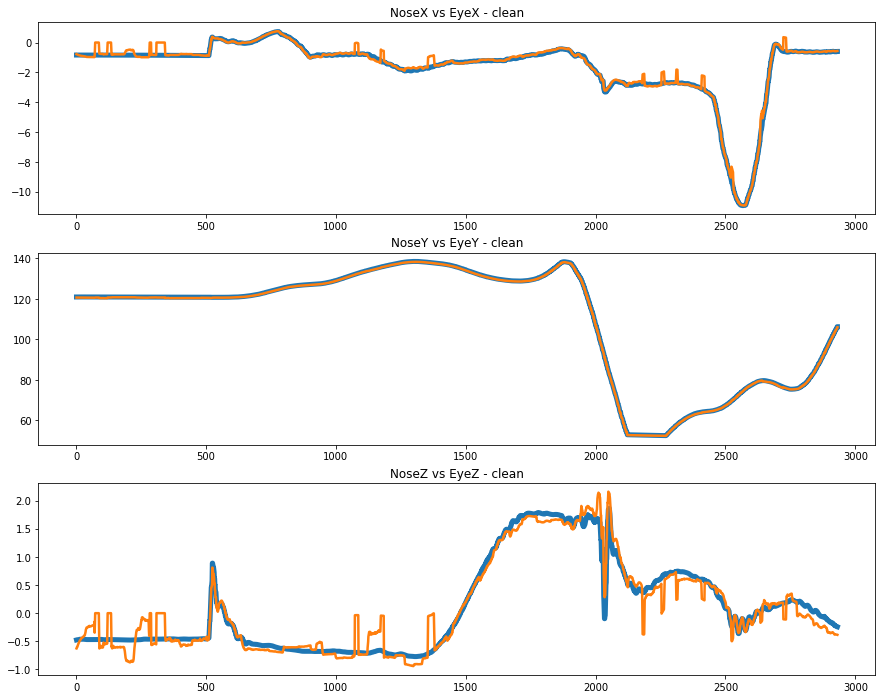

In [17]:
# X

NoseX = ((one_participant_single_segment['NoseVector.x'][1:] - 180) % 360) - 180
NoseX, noseXindex = reject_outliers(NoseX)

EyeX = ((one_participant_single_segment['EyeDirWorldCombined.x'][1:] - 180) % 360) - 180
EyeX, eyeXindex = reject_outliers(EyeX)

X_index_intersection = list(set(noseXindex).intersection(eyeXindex))

# Y

NoseY = ((one_participant_single_segment['NoseVector.y'][1:] - 180) % 360) - 180
NoseY, noseYindex = reject_outliers(NoseY)

EyeY = ((one_participant_single_segment['EyeDirWorldCombined.y'][1:] - 180) % 360) - 180
EyeY, eyeYindex = reject_outliers(EyeY)

Y_index_intersection = list(set(noseYindex).intersection(eyeYindex))

# Z

NoseZ = ((one_participant_single_segment['NoseVector.z'][1:] - 180) % 360) - 180
NoseZ, noseZindex = reject_outliers(NoseZ)

EyeZ = ((one_participant_single_segment['EyeDirWorldCombined.z'][1:] - 180) % 360) - 180
EyeZ, eyeZindex = reject_outliers(EyeZ)

Z_index_intersection = list(set(noseZindex).intersection(eyeZindex))


# Plot 
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.title('NoseX vs EyeX - clean')
plt.plot(NoseX[X_index_intersection], linewidth=5)
plt.plot(EyeX[X_index_intersection], linewidth=2.5)

plt.subplot(3,1,2)
plt.title('NoseY vs EyeY - clean')
plt.plot(NoseY[Y_index_intersection], linewidth=5)
plt.plot(EyeY[Y_index_intersection], linewidth=2.5)

plt.subplot(3,1,3)
plt.title('NoseZ vs EyeZ - clean')
plt.plot(NoseZ[Z_index_intersection], linewidth=5)
plt.plot(EyeZ[Z_index_intersection], linewidth=2.5)

# Power Spectral density on cleaned data

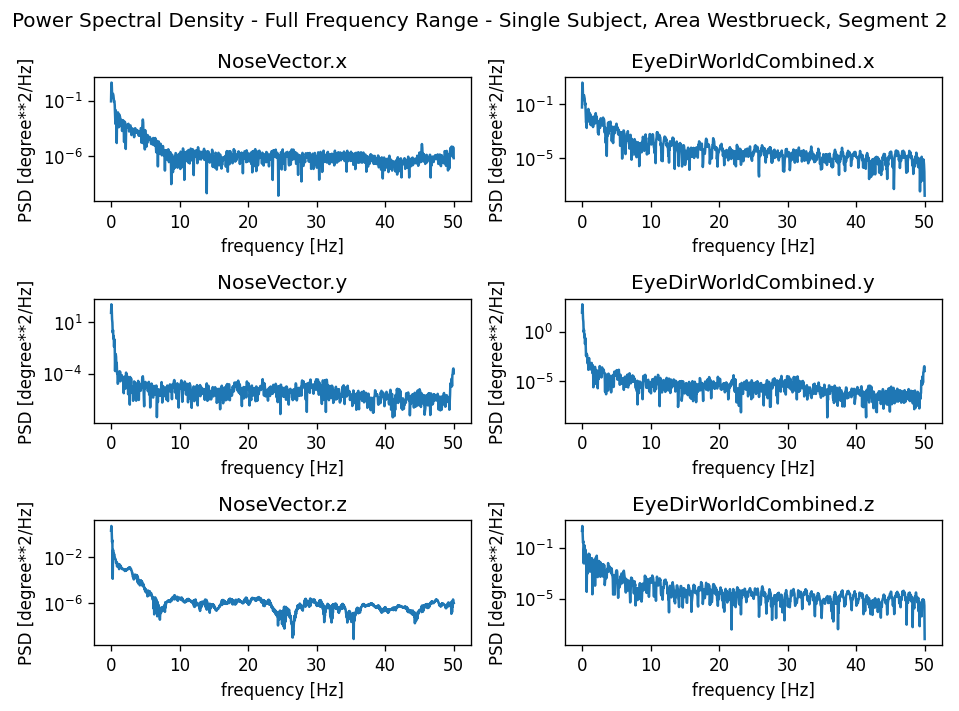

In [204]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
    x, xindex = reject_outliers(x)
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 100])
    #row.set_xlim([0, 2])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

[[1.         0.99489362]
 [0.99489362 1.        ]]
0.7605195045471191


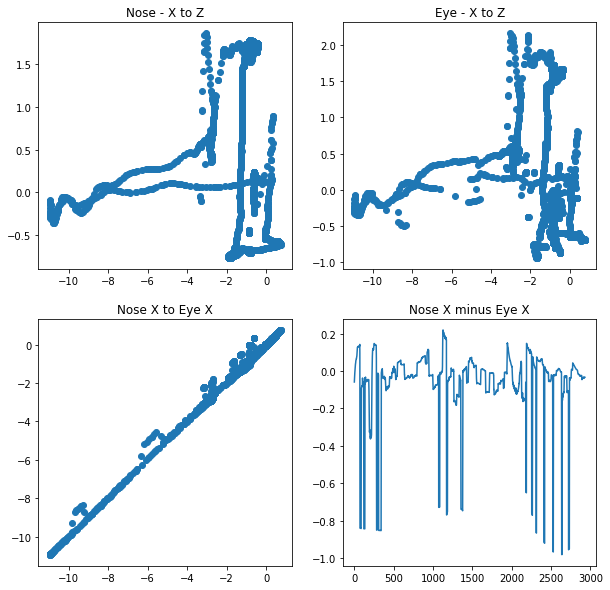

In [217]:
np.corrcoef(one_participant_single_segment['NoseVector.y'], one_participant_single_segment['EyeDirWorldCombined.y'])

#plt.hist(one_participant_single_segment['NoseVector.x'] - one_participant_single_segment['EyeDirWorldCombined.x'])

hmdX = ((one_participant_single_segment['HmdPosition.x'][1:] - 180) % 360) - 180
hmdX, hmdx_index = reject_outliers(hmdX)
hmdY = ((one_participant_single_segment['HmdPosition.y'][1:] - 180) % 360) - 180
hmdY, hmdy_index = reject_outliers(hmdY)
hmdZ = ((one_participant_single_segment['HmdPosition.z'][1:] - 180) % 360) - 180
hmdZ, hmdz_index = reject_outliers(hmdZ)

NoseX = ((one_participant_single_segment['NoseVector.x'][1:] - 180) % 360) - 180
NoseX, noseXindex = reject_outliers(NoseX)
NoseY = ((one_participant_single_segment['NoseVector.y'][1:] - 180) % 360) - 180
NoseY, noseYindex = reject_outliers(NoseY)
NoseZ = ((one_participant_single_segment['NoseVector.z'][1:] - 180) % 360) - 180
NoseZ, noseZindex = reject_outliers(NoseZ)

EyeX = ((one_participant_single_segment['EyeDirWorldCombined.x'][1:] - 180) % 360) - 180
EyeX, eyeXindex = reject_outliers(EyeX)
EyeY = ((one_participant_single_segment['EyeDirWorldCombined.y'][1:] - 180) % 360) - 180
EyeY, eyeYindex = reject_outliers(EyeY)
EyeZ = ((one_participant_single_segment['EyeDirWorldCombined.z'][1:] - 180) % 360) - 180
EyeZ, eyeZindex = reject_outliers(EyeZ)

noseXeyeX_intersection = list(set(noseXindex).intersection(eyeXindex))
nose_intersection = list(set(noseXindex).intersection(noseZindex))
eye_intersection = list(set(eyeXindex).intersection(eyeZindex))

print(np.corrcoef(NoseX,EyeX))

print(np.max(EyeX))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Nose - X to Z')
plt.scatter(NoseX[nose_intersection], NoseZ[nose_intersection])
plt.subplot(2,2,2)
plt.title('Eye - X to Z')
plt.scatter(EyeX[eye_intersection], EyeZ[eye_intersection])
plt.subplot(2,2,3)
plt.title('Nose X to Eye X')
plt.scatter(NoseX, EyeX)
plt.subplot(2,2,4)
plt.title('Nose X minus Eye X')
plt.plot(NoseX[noseXeyeX_intersection]-EyeX[noseXeyeX_intersection])



In [210]:
x = ((average_over_all_participants_single_segment[names_x[idx]][1:] - 180) % 360) - 180
x, index = reject_outliers(x)

x = ((average_over_all_participants_single_segment['NoseVector.x'][1:] - 180) % 360) - 180
x, index = reject_outliers(x)
f_Nose, pxx_den_Nose = signal.welch(x, fs=(1/0.01),nperseg=2048)
    
x = ((average_over_all_participants_single_segment['EyeDirWorldCombined.x'][1:] - 180) % 360) - 180
x = reject_outliers(x)
f_Eye, pxx_den_Eye = signal.welch(x ,fs=(1/0.01),nperseg=2048)


#plt.figure(figsize=(10,10))

#plt.semilogy(f, pxx_den_Nose)#/pxx_den_Eye) 




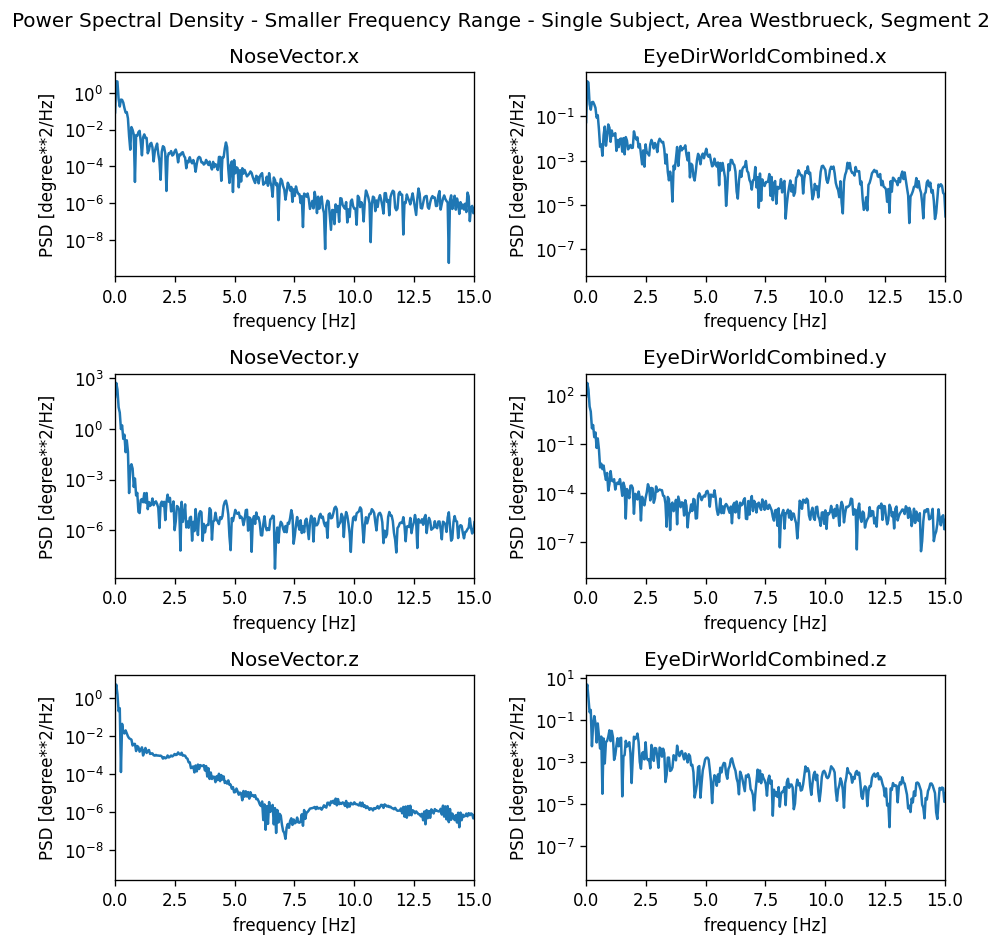

In [209]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]] - 180) % 360) - 180
    x, index = reject_outliers(x)
    
    f, pxx_den = signal.welch(x=x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,15)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

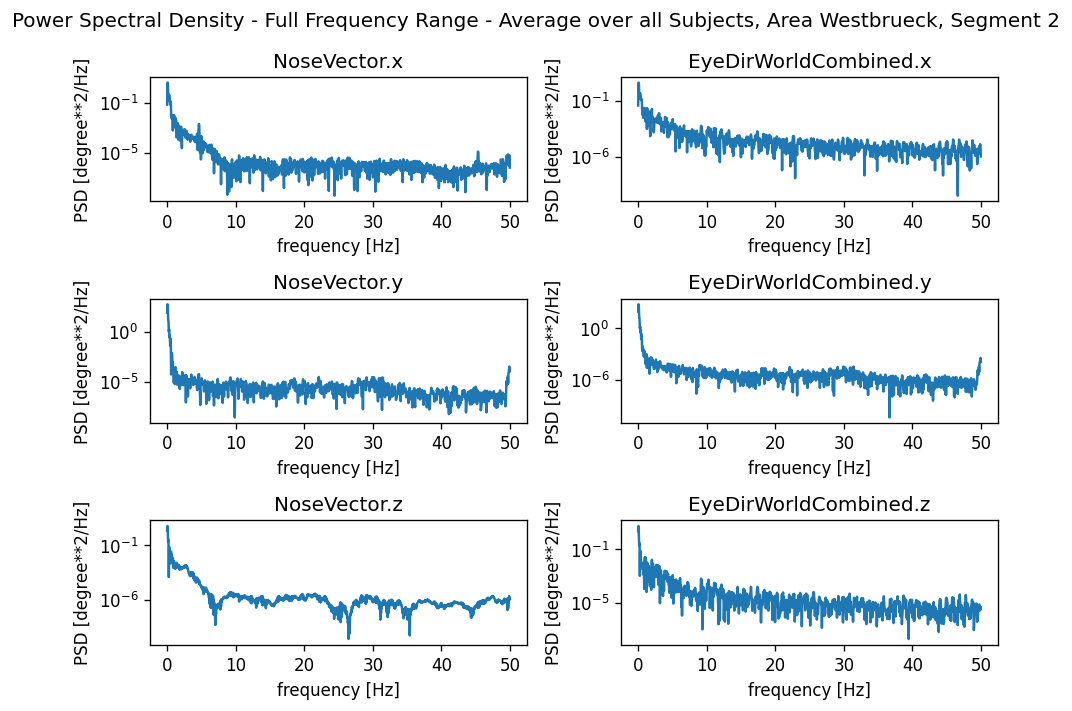

In [83]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((average_over_all_participants_single_segment[names_x[idx]] - 180) % 360) - 180
    x, index = reject_outliers(x)
    
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

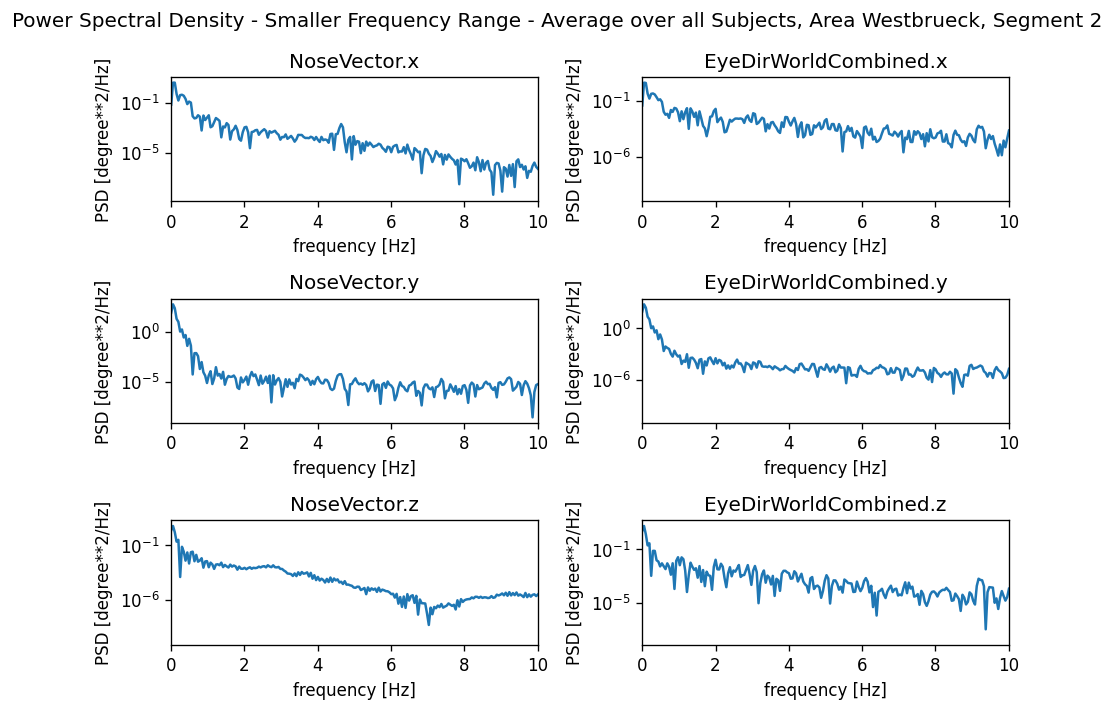

In [84]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    
    x = ((average_over_all_participants_single_segment[names_x[idx]] - 180) % 360) - 180
    x, index = reject_outliers(x)
    
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,10)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

## Cross spectral density

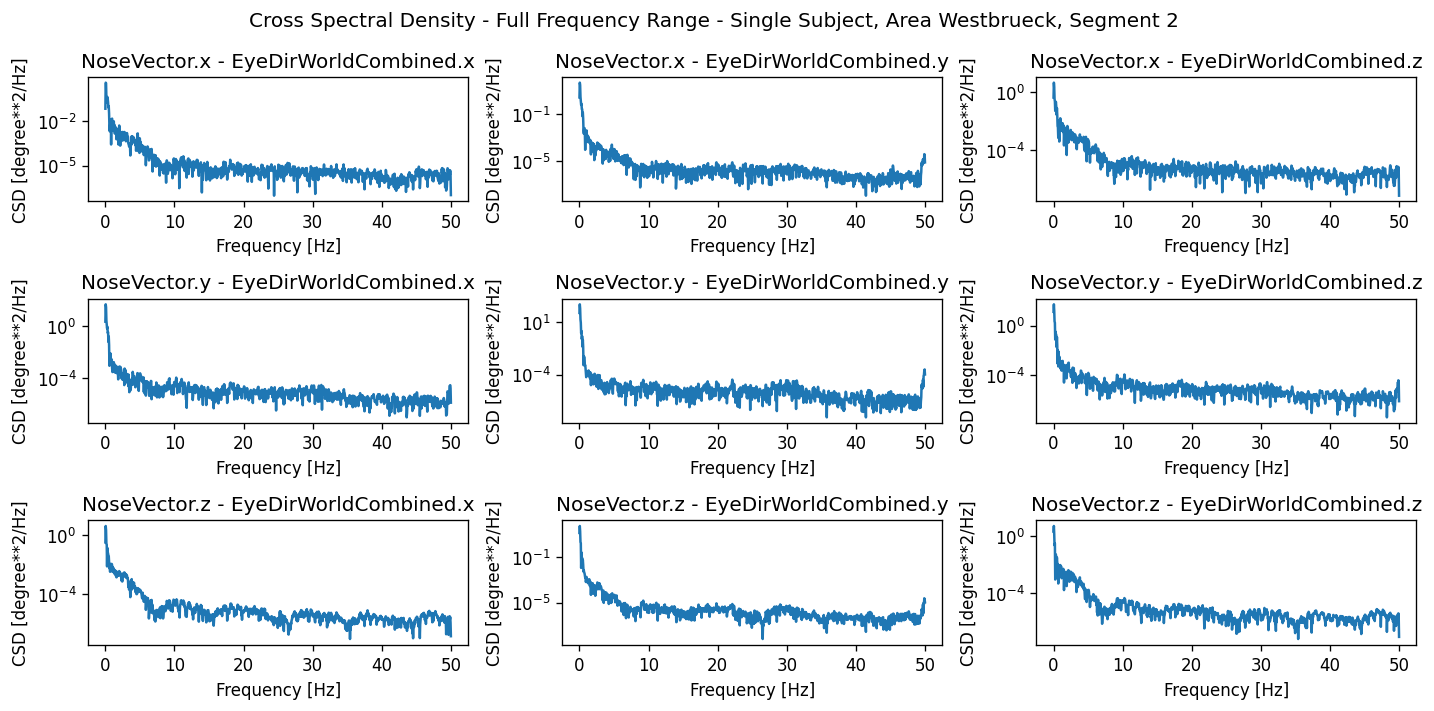

In [208]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x, index = reject_outliers(x)
        y = ((one_participant_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y, yindex = reject_outliers(y)
        
        index_intersection = list(set(xindex).intersection(yindex))
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

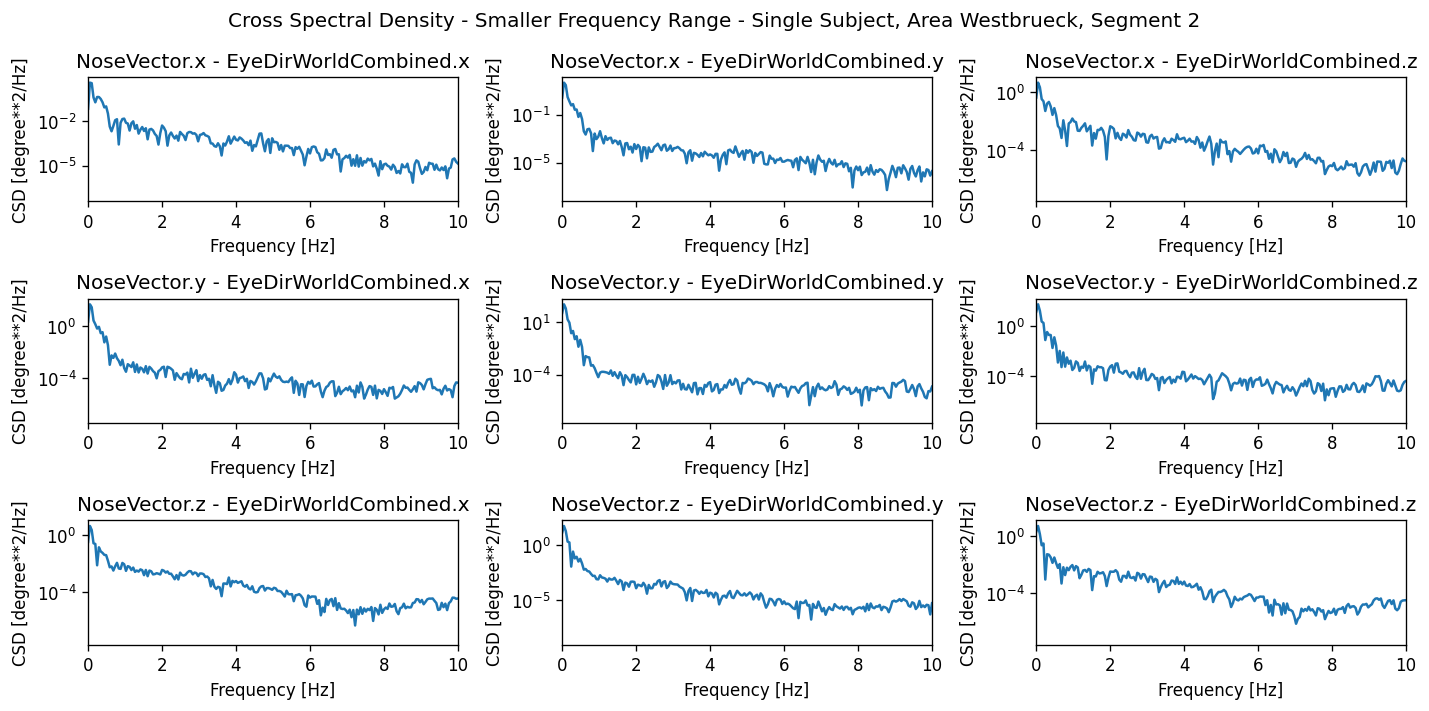

In [205]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x, xindex = reject_outliers(x)
        y = ((one_participant_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y, yindex = reject_outliers(y)
        
        index_intersection = list(set(xindex).intersection(yindex))
        
        sample_freqs, csd = signal.csd(x[index_intersection],y[index_intersection],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

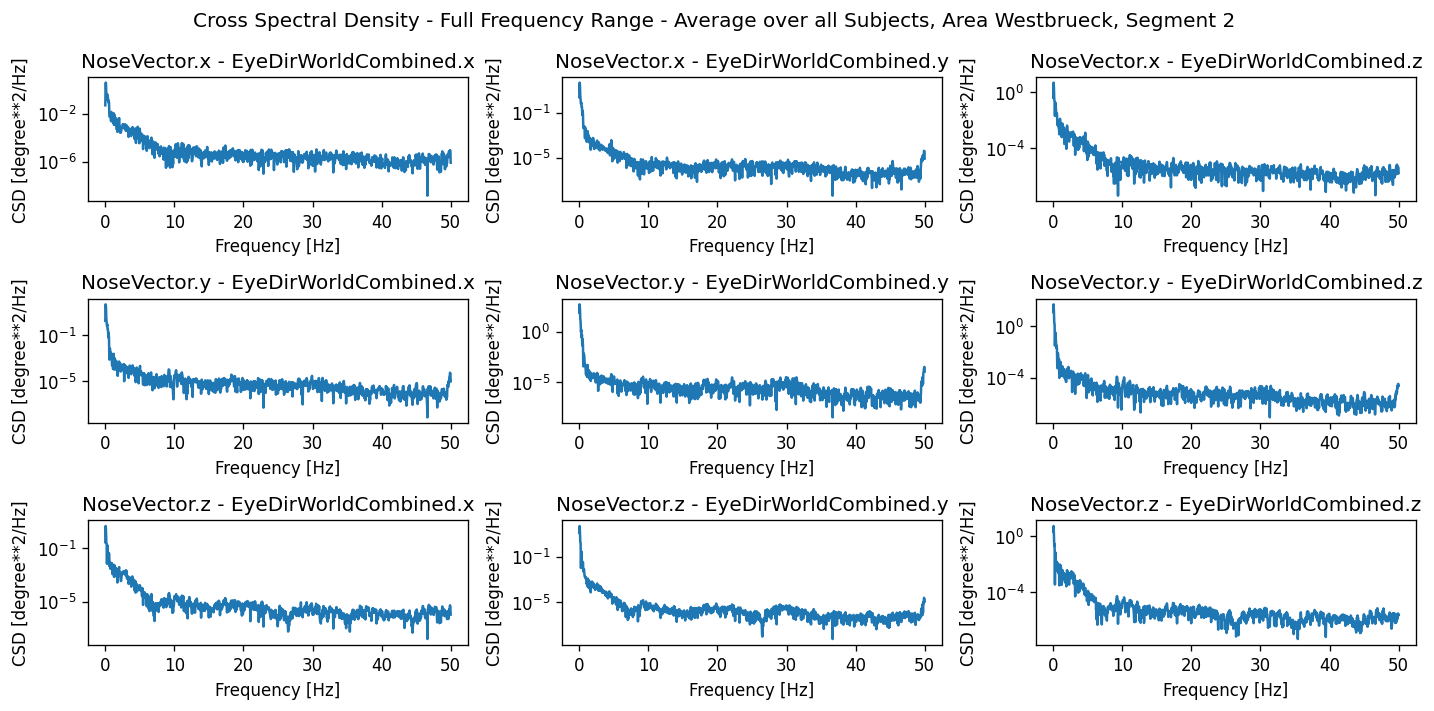

In [88]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = ((average_over_all_participants_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x = reject_outliers(x)
        y = ((average_over_all_participants_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y = reject_outliers(y)
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

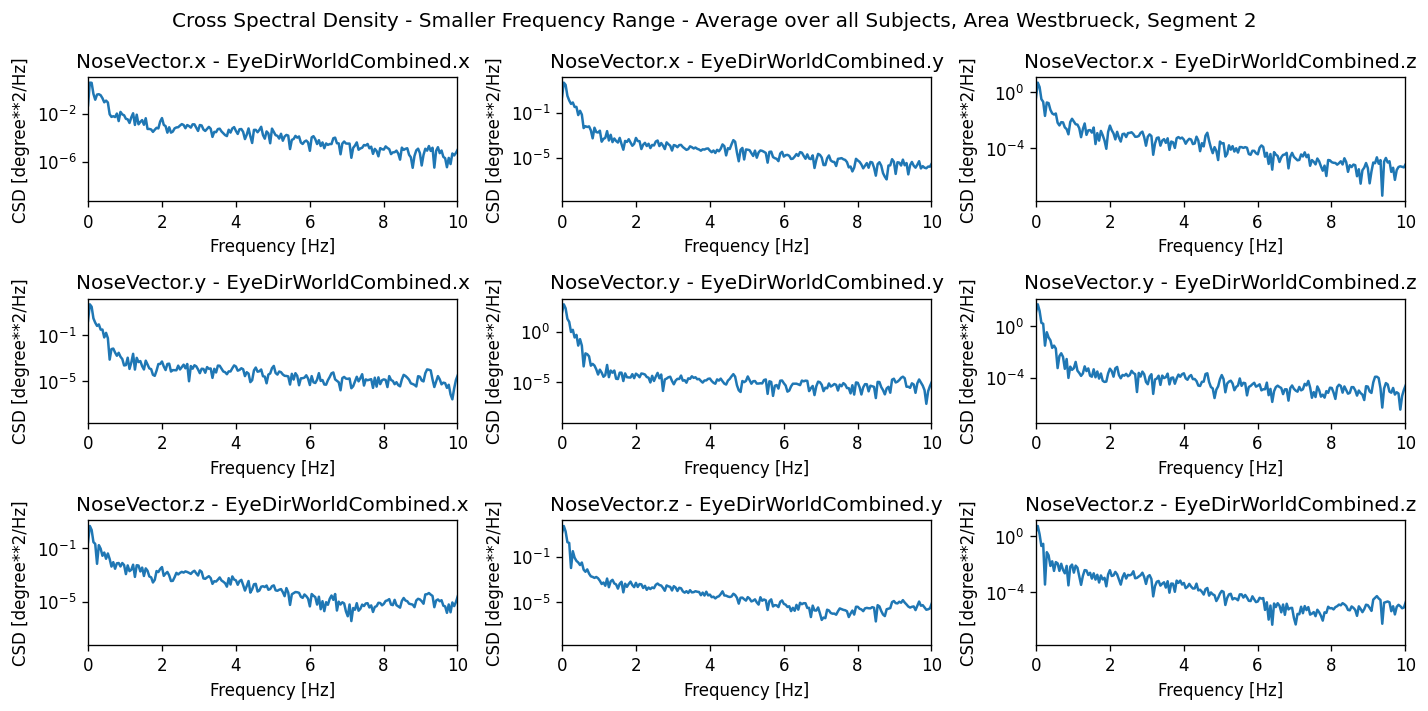

In [89]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):

        x = ((average_over_all_participants_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x = reject_outliers(x)
        y = ((average_over_all_participants_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y = reject_outliers(y)
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()